<a href="https://colab.research.google.com/github/CarysDT/Colab-Notebook/blob/main/Copy_of_Unit8Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

# Load the California Housing dataset
california = fetch_california_housing()
X = pd.DataFrame(california.data, columns=california.feature_names)
y = pd.Series(california.target)

# Select relevant predictors
X = X[['MedInc', 'AveRooms', 'AveOccup', 'HouseAge']]  # Use a subset of features

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X)

In [14]:
# Build the GLM using pymc
with pm.Model() as model:
    # Define priors for the coefficients (beta)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=X_train_scaled.shape[1])

    # Prior for the residual variance (sigma)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Define the linear model: y = X * beta + epsilon
    mu = pm.math.dot(X_train_scaled, beta)

    # Define the linear model as a deterministic variable (this will allow you to track it)
    mu_det = pm.Deterministic('mu', mu)

    # Likelihood: normal distribution for residuals
    likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=y_train)

    # Sample from the posterior distribution using MCMC (NUTS is the default method)
    trace = pm.sample(target_accept=0.9, return_inferencedata=True, chains=4, tune=1000)

Output()

In [16]:
# Extract the posterior predictive samples for 'y' and compute the mean
y_pred = posterior_predictive['posterior_predictive']['y']

In [17]:
# Posterior predictive checks (to evaluate model fit)
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace)
# Check shapes to debug
print(f"y_pred shape: {y_pred.shape}")   # Should be (n_draws, 16512)
print(f"y_train shape: {y_train.shape}") # Should be (16512,)

# Compute the mean prediction per observation
y_pred_mean = y_pred.mean(axis=0)

# Check shape match
print(f"y_pred_mean shape: {y_pred_mean.shape}")

Output()

y_pred shape: (4, 1000, 16512)
y_train shape: (16512,)
y_pred_mean shape: (1000, 16512)


ValueError: x and y must be the same size

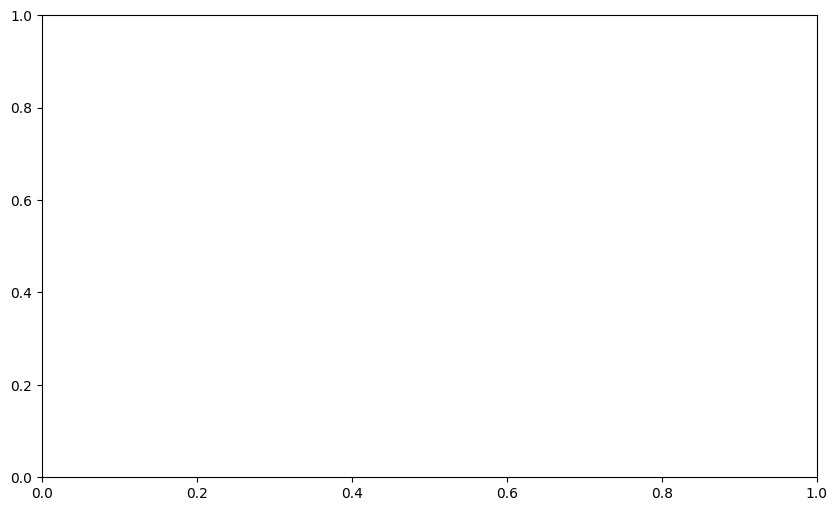

In [18]:
# Now plotting will work
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_mean, alpha=0.5, label='Posterior Predictive Mean')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', label='Perfect Prediction')
plt.xlabel("Observed Y (training)")
plt.ylabel("Predicted Y (posterior mean)")
plt.title("Posterior Predictive Check")
plt.legend()
plt.grid(True)
plt.show()

Output()

KeysView(Inference data with groups:
	> posterior_predictive
	> observed_data)
Shape of posterior predictive samples: (4, 1000, 16512)
Length of y_train: 16512
Length of y_pred_mean: 1000


ValueError: x and y must be the same size

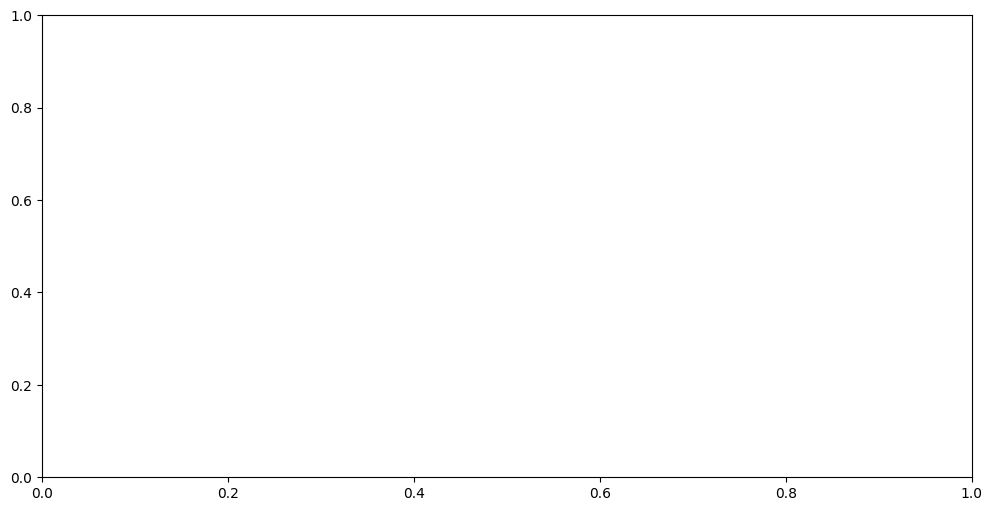

In [3]:
# Posterior predictive checks (to evaluate model fit)
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace)

# Check the keys in posterior predictive to find the relevant variable
print(posterior_predictive.keys())  # Check the keys of the posterior predictive dictionary

# Custom Posterior Predictive Check visualization
# Visualize observed vs. predicted data
plt.figure(figsize=(12, 6))

# Extract the posterior predictive samples for 'y' and compute the mean
y_pred = posterior_predictive['posterior_predictive']['y']

# Check the shape of y_pred
print(f"Shape of posterior predictive samples: {y_pred.shape}")

# Ensure we are using the same number of observations as in y_train
y_pred_mean = y_pred[:, :len(y_train)].mean(axis=0)  # Get mean of posterior predictive samples for the training set

# Check the shape of y_train and y_pred_mean
print(f"Length of y_train: {len(y_train)}")
print(f"Length of y_pred_mean: {len(y_pred_mean)}")

# Plot observed vs. predicted values
plt.scatter(y_train, y_pred_mean, label="Posterior Predictive Mean", alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', label='Perfect Prediction')

# Plot the actual values
plt.scatter(y_train, y_train, label="Observed", color='r', alpha=0.3)

plt.xlabel('Observed Values')
plt.ylabel('Predicted Values (Posterior Predictive Mean)')
plt.title('Posterior Predictive Check')
plt.legend()
plt.show()


In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
!pip install bambi
import bambi as bmb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 4.2 MB/s eta 0:00:00


In [3]:
# Load California Housing dataset
california = fetch_california_housing()
X = pd.DataFrame(california.data, columns=california.feature_names)
y = pd.Series(california.target)

# Select relevant predictors
X = X[['MedInc', 'AveRooms', 'AveOccup', 'HouseAge']]  # Use a subset of features

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
X

,MedInc,AveRooms,AveOccup,HouseAge
0,8.3252,6.984127,2.555556,41.0
1,8.3014,6.238137,2.109842,21.0
2,7.2574,8.288136,2.802260,52.0
3,5.6431,5.817352,2.547945,52.0
4,3.8462,6.281853,2.181467,52.0
...,...,...,...,...
20635,1.5603,5.045455,2.560606,25.0
20636,2.5568,6.114035,3.122807,18.0
20637,1.7000,5.205543,2.325635,17.0
20638,1.8672,5.329513,2.123209,18.0


In [5]:
y

,0
0,4.526
1,3.585
2,3.521
3,3.413
4,3.422
...,...
20635,0.781
20636,0.771
20637,0.923
20638,0.847


In [6]:
# Build the GLM using pymc
with pm.Model() as model:
    # Define priors for the coefficients (beta)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=X_train_scaled.shape[1])

    # Prior for the residual variance (sigma)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Define the linear model: y = X * beta + epsilon
    mu = pm.math.dot(X_train_scaled, beta)

    # Define the linear model as a deterministic variable (this will allow you to track it)
    mu_det = pm.Deterministic('mu', mu)

    # Likelihood: normal distribution for residuals
    likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=y_train)

    # Sample from the posterior distribution using MCMC (Metropolis-Hastings or NUTS)
    trace = pm.sample(target_accept=0.9, return_inferencedata=True)

Output()

In [9]:
# Posterior predictive checks (to evaluate model fit)
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace)

Output()

In [15]:
y_pred = posterior_predictive['posterior_predictive']['y']

In [18]:
# Ensure we are using the same number of observations as in y_train
y_pred_mean = y_pred.mean(axis=0)[:len(y_train)]

In [23]:
# Ensure we are using the same number of observations as in y_train
y_pred_meana = y_pred.mean(axis=0)[:len(y_train)]  # Get mean of posterior predictive samples for the training set

# Check the shape of y_train and y_pred_mean
print(f"Length of y_train: {len(y_train)}")
print(f"Length of y_pred_mean: {len(y_pred_mean)}")

Length of y_train: 16512
Length of y_pred_mean: 1000


ValueError: x and y must be the same size

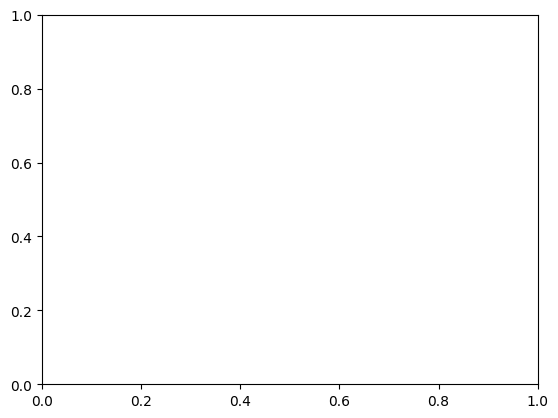

In [24]:
# Plot observed vs. predicted values
plt.scatter(y_train, y_pred_meana, label="Posterior Predictive Mean", alpha=0.6)

ValueError: x and y must be the same size

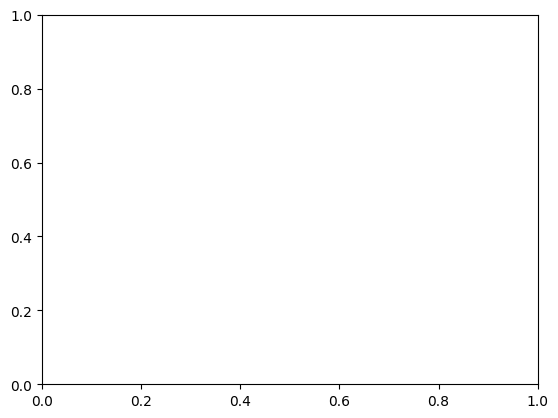

In [20]:
# Plot observed vs. predicted values
plt.scatter(y_train, y_pred_mean, label="Posterior Predictive Mean", alpha=0.6)

In [ ]:
# Posterior predictive checks (to evaluate model fit)
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace)

In [19]:
# Generate predictions on the test set
with model:
    # Use the posterior samples to make predictions
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["beta", "sigma"])

Output()

In [20]:
# Check the available variables in posterior_predictive
print(posterior_predictive.keys())

KeysView(Inference data with groups:
	> posterior_predictive
	> observed_data)


In [16]:
# Extract the posterior samples for 'beta'
beta_samples = posterior_predictive['beta']

KeyError: 'beta'

In [14]:
# Extract predictions for the target variable
y_pred = np.dot(X_test_scaled, posterior_predictive['beta'].T)

KeyError: 'beta'

In [13]:
# Posterior predictive checks
# Sample posterior predictions
ppc = az.from_pymc3(trace=trace, model=model)

# You can access the posterior predictive samples for 'Target'
posterior_predictive = ppc['posterior_predictive']['Target']

# Check the shape of the posterior predictive samples
print(posterior_predictive.shape)

AttributeError: module 'arviz' has no attribute 'from_pymc3'

In [7]:
# Build the BART model using pymc-bart
with pm.Model() as model:
    # Initialize the BART model
    bart = pmb.BART("bart", X=X, Y=y)
    # Define the likelihood (Normal distribution for residuals)
    sigma = pm.HalfNormal('sigma', sigma=1)
    # The BART model output is a tensor that we can use as the expected value for the Normal distribution
    likelihood = pm.Normal('y', mu=bart, sigma=sigma, observed=y)
    # Sample from the posterior distribution
    trace = pm.sample(compute_convergence_checks=False)

NameError: name 'pmb' is not defined

Your file on your github needs to be a a .ipynb file with the first four letters of one first name, the first four letters of one last name, and U6proj.

Ex1.

A student named Avy Aguacate Avocado Palta will submit a file named "Avy_AvocU8proj.ipynb", since she normally just goes by Avy, and, when pressed, reports Avocado as her last name. The " _ " after "Avy" serves as the fourth "letter" in her first name.

Ex2.

Army Armadillo will submit a file named "ArmyArmaU8proj.ipynb"

# Unit 8 Project: Writing a BARTical

**Task**:

Two parts:

1. Propose a data set that's compatible with a pymc_bart model. I must approve your submission before you move on to part 2.

2. Create, analyze, and present BART model, using pymc_bart within the colab environment, on a data set of your choice, with the following conditions:
  - your final model must have more than 2 predictors. The intercept term doesn't count as a predictor here (even though technically it is)
  - You must argue why your variable selection is justified. You may use either a theoretical or numerical argument. Additionally, you must comment on any potential interactions between your predictor variables.



Guidlines:

- Your data or your model type must be different from any project you've previously done.

- You are allowed to copy and paste any code from the notes, including my answer key (AK), without any reference or citations. Same goes for the course textbook, BAP3.

- This is an individual project. It is fine if you model the same process as a peer, but your raw data **must** be substantially different. "Substantially different" means that I, your instructor, arbitrarily think your data sets are different enough.

- Do not look at other student's code/jupyter notebooks. Copying, or copying and pasting, other students code will result in a failing grade. Also, I will tell all the other teachers I know that you cheated.

- If you want to know what another student did, ask them--any verbal communication about a project is allowed and encouraged. If you want to see a graphic they made, ask them to sketch a picture of it for you by hand.

- Any handwritten communication is also allowed and encouraged, so long as all parties are in the same physical location together. Example: you may sketch out a piece of code while verbally explaining to someone what you did. Do NOT: hand write the code for your entire project, take a picture, and send it to everyone in the course.

- If you use someone's code from outside this course (like from the internet, an AI, or your parent), you must ask me if it is ok, and you must cite them in your work. I don't care all they did was to click your space bar one more time: you tell me, and you cite their contribution. You don't need to tell me about or cite verbal or handwritten communication though.

- You may use a more complicated model--like something from further along in the course--IF I give you permission.

- If you are unsure whether or not something is ok or allowed: ASK BEFORE YOU DO IT.

Faliure to adhere to these guidlines will result in a failing grade.

Tips:

- Try to pick something that you care about, have knowledge of, experience with, or that you find interesting/cool.

- Gather data *before* picking a model or likelihood.

-  Use your best idea now; maybe you can look at the context you used in the previous project, and gather different data from it.

- Choose a data set with lots of columns, and lots of potential interactions between variables. It'll be more fun, and will make model/variable selection more relevant.

- Comment heavily, and explain your steps and thought process with text blocks. This is not only requried, it'll also help you understand what you're doing and what you want to do.

- Its ok to pick a data set for which you don't qute understand the context--so long as you think the context is cool.
